## Linear classifier trained with the optimization of a Logistic Loss Function
#### 1. Set enviroment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Here the path of the main git folder. *C:/.../optimization* if your in local or */content/gdrive/My Drive/.../"your_folder_name"*


In [21]:
cd /content/gdrive/My Drive/Colab Notebooks/Optim/Homework1

/content/gdrive/My Drive/Colab Notebooks/Optim/Homework1


### 2. Import libraries
The custom script should be located in the folfer *src*

In [0]:
import numpy as np

import src.model as model
import src.optimizer as optimizer
import src.loss as loss

import time
import json
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from tabulate import tabulate

### 3. Helping functions

In [0]:
"""
Load either IRIS/mnist/a9a dataset.
Return X_train, X_test, y_train, y_test
"""
def get_data(data):
    if data == 'iris':
        data = load_iris()
        inp, y = data['data'], data['target']
        X = inp[y < 2]
        y = y[y < 2]
        y[y == 0] = -1
        y = np.reshape(y, (-1, 1))
        ### Splitting dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
        return  X_train, X_test, y_train, y_test
    ### MNIST with digit 1 and 7
    elif data == 'mnist':
        from scipy.io import loadmat
        mnist = loadmat('MNIST.mat')
        X, y = mnist['input_images'], mnist['output_labels']
        X = X[(y.reshape(-1) == 1) | (y.reshape(-1) == 7)]
        y = y[(y == 1) | (y == 7)]
        y[y == 1] = 1
        y[y == 7] = -1
        y = np.reshape(y, (-1, 1))
        ### Splitting dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
        return  X_train, X_test, y_train, y_test
    ### a9a
    elif data == 'a9a':
        X_train = np.genfromtxt('a9a/a9a_train.csv', delimiter=',', skip_header=True)[:, 1:]
        y_train = np.genfromtxt('a9a/a9a_train.csv', delimiter=',', skip_header=True)[:, 0].reshape(-1, 1)
        X_test = np.genfromtxt('a9a/a9a_test.csv', delimiter=',', skip_header=True)[:, 1:]
        y_test = np.genfromtxt('a9a/a9a_test.csv', delimiter=',', skip_header=True)[:, 0].reshape(-1, 1)
        # Balance
        length = np.sum(y_train == 1)
        idx1 = y_train.reshape(-1) == 1
        idx0 = y_train.reshape(-1) == -1
        X_train = np.concatenate((X_train[idx1, :], X_train[idx0, :][:length]), axis=0)
        y_train = np.concatenate((y_train[idx1, :], y_train[idx0, :][:length]), axis=0)
        # Shuffle
        X_train, y_train = shuffle(X_train, y_train)
        X = np.concatenate((X_train, X_test), axis=0)
        y = np.concatenate((y_train, y_test), axis=0)
        return  X_train, X_test, y_train, y_test

"""
Inititialize model, loss, and optim
"""
def init(params, X_train):
    clf = model.Model(input_size=X_train.shape[1], init_weights=params['init_weights'])
    my_loss = loss.LogisticLoss(reg_coeff=params['wd'])
    optim = init_optim(params, clf.weights, my_loss)
    return clf, optim

"""
Initialize optimizer (used internally in init)
"""
def init_optim(params, weights, my_loss):
    if params['optim'] == 'gd':
        optim = optimizer.GD(params=weights, loss=my_loss, learn_rate=params['lr'], tollerance=params['tollerance'])
    elif params['optim'] == 'sgd':
        optim = optimizer.SGD(params=weights, loss=my_loss, learn_rate=params['lr'], tollerance=params['tollerance'])
    elif params['optim'] == 'svrg':
        optim = optimizer.SVRG(params=weights, loss=my_loss, learn_rate=params['lr'], tollerance=params['tollerance'], iter_epoch=params['iter_epoch'])
    else:
        raise NotImplementedError
    return optim

"""
Compute the accuracy given a list of weights
"""
def get_accuracy(clf, X_test, y_test, weights):
    ### Computing accuracy for each step
    X_testb = clf.add_bias(X_test)
    accuracy_list = []

    for weight in tqdm(weights):
        # 1. Get output
        y_pred = np.dot(X_testb, weight)
        # 2. Compute accuracy
        y_pred[y_pred > 0] = 1
        y_pred[y_pred <= 0] = -1
        accuracy_list.append(accuracy_score(y_test, y_pred))
    return accuracy_list

"""
Moving avarage of an array 'a' of size 'n'
"""
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

### 4. Single Fit
Fit a single model given some parameters

In [22]:
### 1. Define the params
params = {'data': 'mnist', 'init_weights': 'random', 'wd': 0.002, 'optim': 'svrg', 'lr': 0.05, 'tollerance': 0.0001, 'iter_epoch': 9109, 'epochs': 3}
### 2. Get Data
X_train, X_test, y_train, y_test = get_data(params['data'])
### 3. Create model
clf, optim = init(params, X_train)
### 4. Fit model
results = clf.fit(X=X_train, y=y_train, optimizer=optim, num_epochs=params['epochs'])
print('Model fitted in: {:.3f}'.format(results['time_list'][-1]))
### 5. Get accuracy results
accuracy = get_accuracy(clf, X_test, y_test, results['params_list'])

  0%|          | 45/27327 [00:00<01:00, 449.56it/s]

Model fitted in: 2.899


100%|██████████| 27327/27327 [00:59<00:00, 457.33it/s]


In [23]:
accuracy[-1]

0.9918032786885246

### 5. Evaluation with different parameters


In [24]:
"""
Main function which does the work seen in Point 4.
"""
def main(params):
    X_train, X_test, y_train, y_test = get_data(params['data'])
    clf, optim = init(params, X_train)
    results = clf.fit(X=X_train, y=y_train, optimizer=optim, num_epochs=params['epochs'])
    results['accuracy_list'] = get_accuracy(clf, X_test, y_test, results['params_list'])
    return results

### 1. Define the parameters of every main cycle
param_list = [ #{'data': 'a9a',   'init_weights': 'random', 'wd': 0.002, 'optim': 'gd',   'lr': 0.3,  'tollerance': 0.01,   'iter_epoch': 10000, 'epochs': 700},
               #{'data': 'a9a',   'init_weights': 'random', 'wd': 0.001, 'optim': 'sgd',  'lr': 0.01, 'tollerance': 0.0001, 'iter_epoch': 10000, 'epochs': 3},
               #{'data': 'a9a',   'init_weights': 'random', 'wd': 0.001, 'optim': 'svrg', 'lr': 0.05, 'tollerance': 0.0001, 'iter_epoch': 15682, 'epochs': 3},
               {'data': 'mnist', 'init_weights': 'random', 'wd': 0.002, 'optim': 'gd',   'lr': 0.2,  'tollerance': 0.01,   'iter_epoch': 10000, 'epochs': 300},
               {'data': 'mnist', 'init_weights': 'random', 'wd': 0.002, 'optim': 'sgd',  'lr': 0.05, 'tollerance': 0.0001, 'iter_epoch': 10000, 'epochs': 3},
               {'data': 'mnist', 'init_weights': 'random', 'wd': 0.002, 'optim': 'svrg', 'lr': 0.05, 'tollerance': 0.0001, 'iter_epoch': 9109,  'epochs': 3}]

### 2. Set seed
np.random.seed = 42

### 3. Call the main function for every parameter in the list
res = []
for n, params in enumerate(param_list):
    # 3.1 Run Main
    print('Start iteration {}/{} with following parameters:\n{}'.format(n+1, len(param_list), params))
    results = main(params)
    # 3.2 Print results
    print('Results are:')
    print('\tLoss: {:.5f}'.format(results['loss_list'][-1]))
    print('\tScore: {:.5f}'.format(results['accuracy_list'][-1]))
    print('\tTime: {:.5f}'.format(results['time_list'][-1]))
    # 3.3 Save results
    results['params_list'] = None
    res.append((params, results))
    print('----------------------------------------------------')
    print('----------------------------------------------------')

### 4. Save results
with open('results_v2.json', 'w') as f:
    json.dump(res, f)

Start iteration 1/3 with following parameters:
{'data': 'mnist', 'init_weights': 'random', 'wd': 0.002, 'optim': 'gd', 'lr': 0.2, 'tollerance': 0.01, 'iter_epoch': 10000, 'epochs': 300}


100%|██████████| 300/300 [00:00<00:00, 441.67it/s]


Results are:
	Loss: 0.66110
	Score: 0.97976
	Time: 10.66432
----------------------------------------------------
----------------------------------------------------
Start iteration 2/3 with following parameters:
{'data': 'mnist', 'init_weights': 'random', 'wd': 0.002, 'optim': 'sgd', 'lr': 0.05, 'tollerance': 0.0001, 'iter_epoch': 10000, 'epochs': 3}


100%|██████████| 27327/27327 [00:59<00:00, 456.76it/s]


Results are:
	Loss: 0.01625
	Score: 0.99436
	Time: 1.73540
----------------------------------------------------
----------------------------------------------------
Start iteration 3/3 with following parameters:
{'data': 'mnist', 'init_weights': 'random', 'wd': 0.002, 'optim': 'svrg', 'lr': 0.05, 'tollerance': 0.0001, 'iter_epoch': 9109, 'epochs': 3}


100%|██████████| 27327/27327 [00:59<00:00, 456.11it/s]


Results are:
	Loss: 0.03065
	Score: 0.99283
	Time: 2.80133
----------------------------------------------------
----------------------------------------------------


### 6. Show results

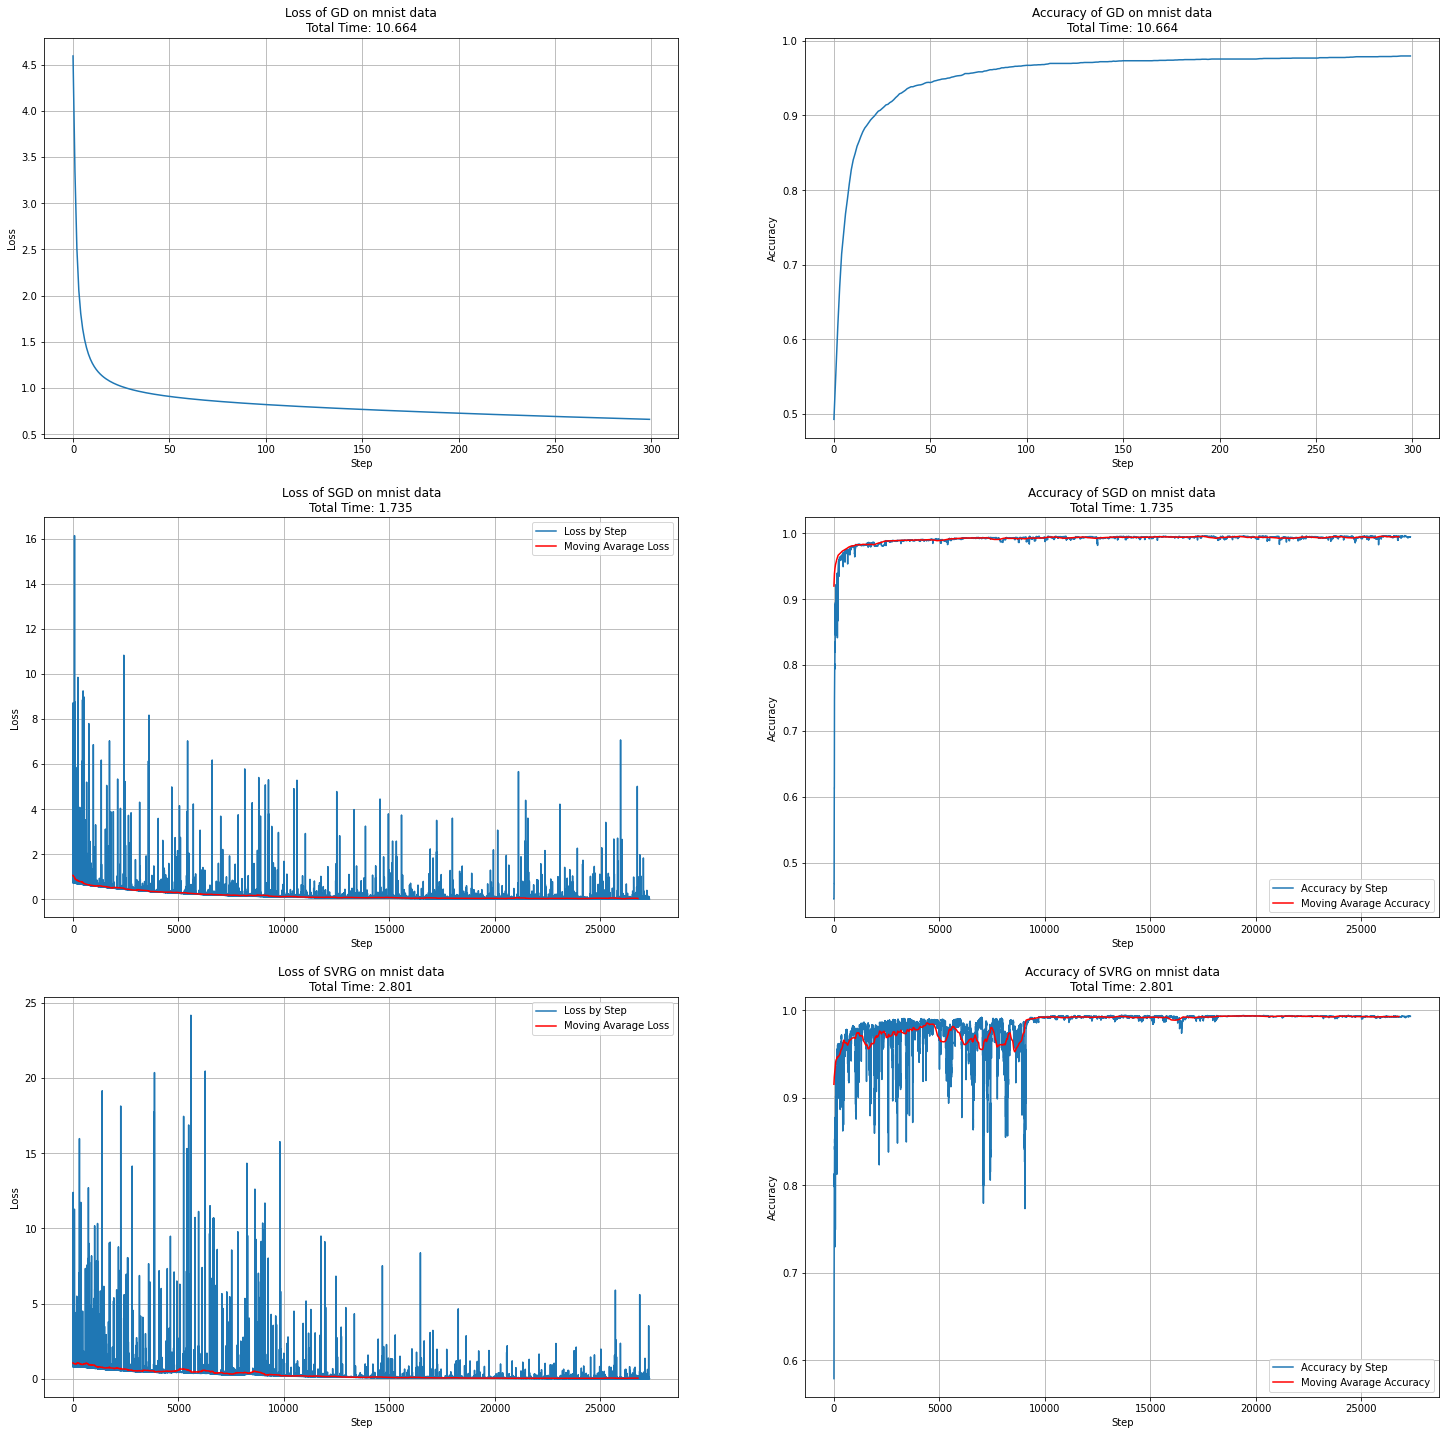

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(25, 25))
for n, r in enumerate(res[:3]):
    ## Loss
    ax[n, 0].plot(r[1]['loss_list'], label='Loss by Step')
    ax[n, 0].set_title('Loss of {} on {} data\nTotal Time: {:.3f}'.format(r[0]['optim'].upper(), r[0]['data'], r[1]['time_list'][-1]))
    ax[n, 0].set_xlabel('Step')
    ax[n, 0].set_ylabel('Loss')
    ax[n, 0].grid()
    ## Accuracy
    ax[n, 1].plot(r[1]['accuracy_list'], label= 'Accuracy by Step')
    ax[n, 1].set_title('Accuracy of {} on {} data\nTotal Time: {:.3f}'.format(r[0]['optim'].upper(), r[0]['data'], r[1]['time_list'][-1]))
    ax[n, 1].set_xlabel('Step')
    ax[n, 1].set_ylabel('Accuracy')
    ax[n, 1].grid()

    ### Compute Moving Average and add legend if not GD
    if r[0]['optim'] != 'gd':
        mean_loss = moving_average(r[1]['loss_list'], np.max([1, len(r[1]['loss_list'])//50]))
        mean_accuracy = moving_average(r[1]['accuracy_list'], np.max([1, len(r[1]['accuracy_list'])//50]))
        ax[n, 0].plot(mean_loss, c='r', label='Moving Avarage Loss')
        ax[n, 1].plot(mean_accuracy, c='r', label='Moving Avarage Accuracy')
        ax[n, 0].legend()
        ax[n, 1].legend()

plt.show()

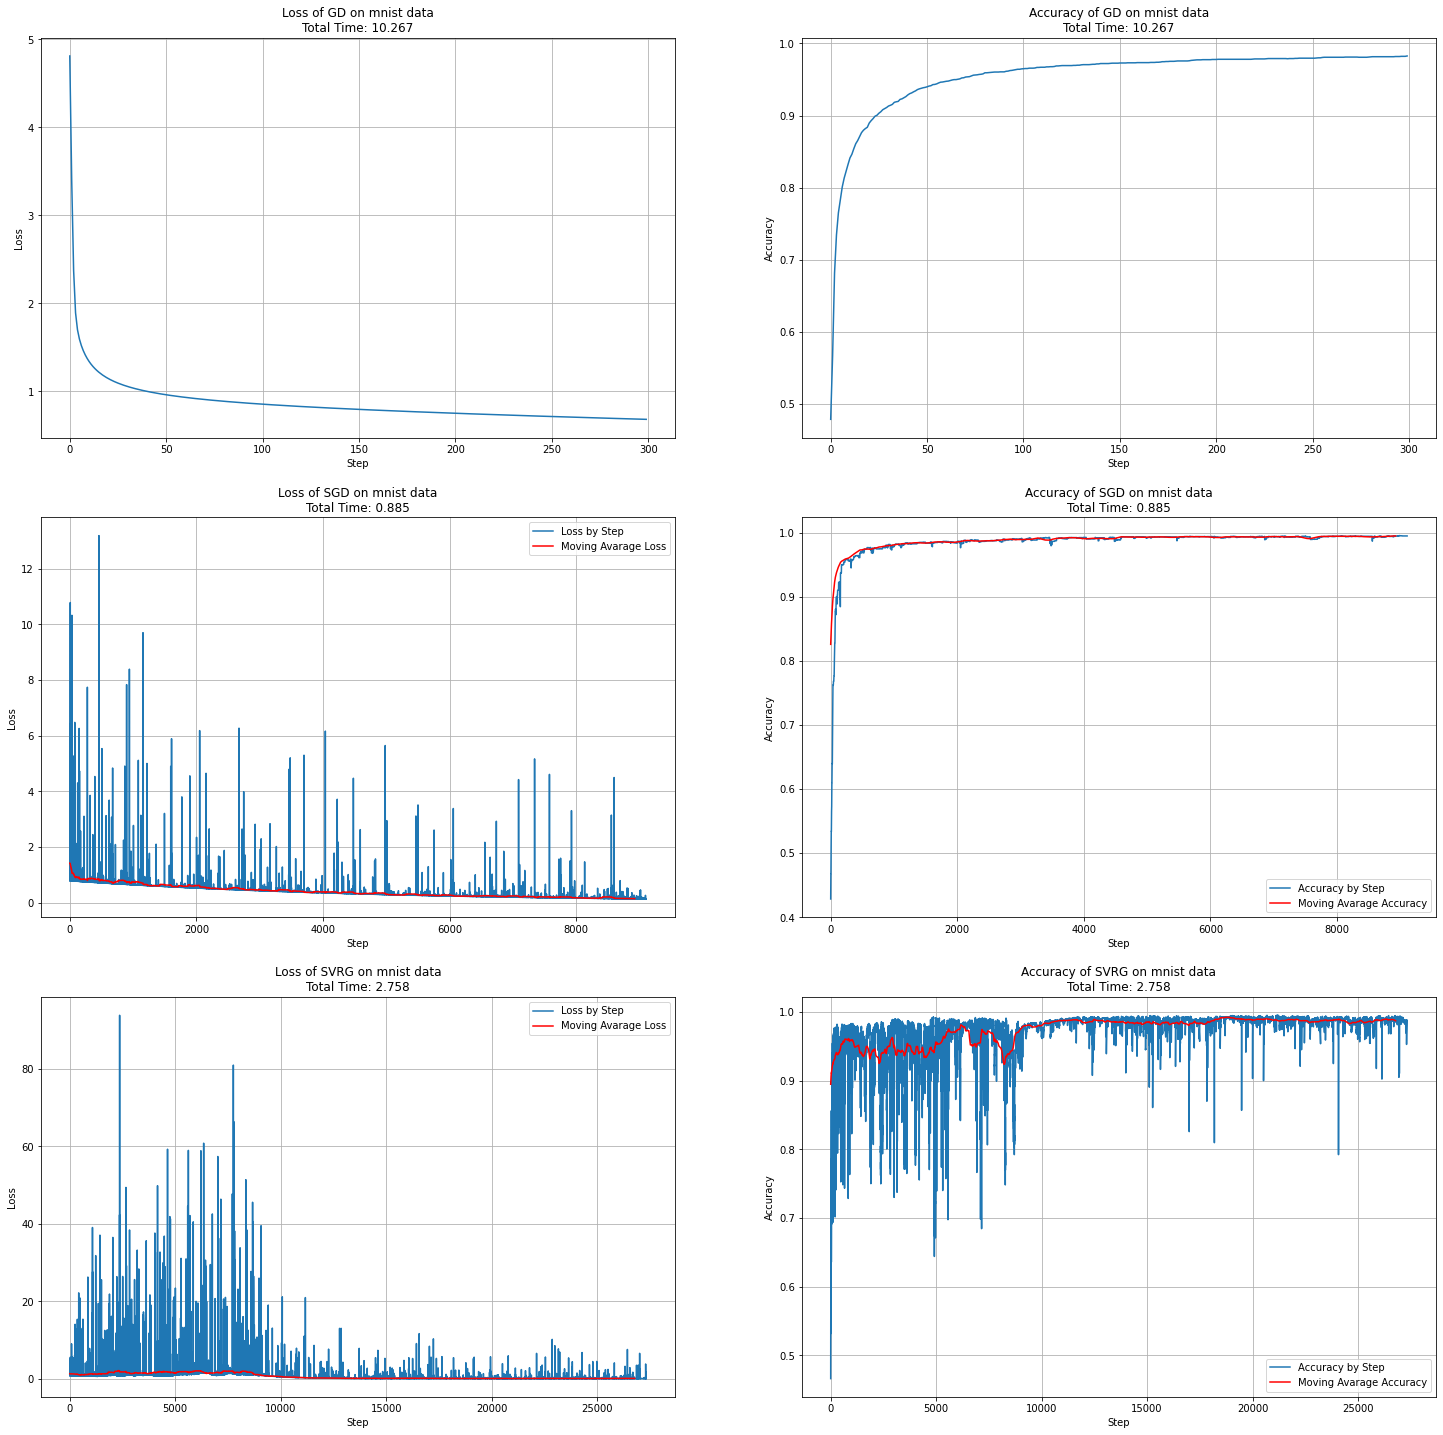

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(25, 25))
for n, r in enumerate(res[3:]):
    ## Loss
    ax[n, 0].plot(r[1]['loss_list'], label='Loss by Step')
    ax[n, 0].set_title('Loss of {} on {} data\nTotal Time: {:.3f}'.format(r[0]['optim'].upper(), r[0]['data'], r[1]['time_list'][-1]))
    ax[n, 0].set_xlabel('Step')
    ax[n, 0].set_ylabel('Loss')
    ax[n, 0].grid()
    ## Accuracy
    ax[n, 1].plot(r[1]['accuracy_list'], label= 'Accuracy by Step')
    ax[n, 1].set_title('Accuracy of {} on {} data\nTotal Time: {:.3f}'.format(r[0]['optim'].upper(), r[0]['data'], r[1]['time_list'][-1]))
    ax[n, 1].set_xlabel('Step')
    ax[n, 1].set_ylabel('Accuracy')
    ax[n, 1].grid()

    ### Compute Moving Average and add legend if not GD
    if r[0]['optim'] != 'gd':
        mean_loss = moving_average(r[1]['loss_list'], np.max([1, len(r[1]['loss_list'])//50]))
        mean_accuracy = moving_average(r[1]['accuracy_list'], np.max([1, len(r[1]['accuracy_list'])//50]))
        ax[n, 0].plot(mean_loss, c='r', label='Moving Avarage Loss')
        ax[n, 1].plot(mean_accuracy, c='r', label='Moving Avarage Accuracy')
        ax[n, 0].legend()
        ax[n, 1].legend()

plt.show()

In [26]:
cd results

/content/gdrive/My Drive/Colab Notebooks/Optim/Homework1/results


In [0]:
### 4. Save results
with open('results_v3_mnist.json', 'w') as f:
    json.dump(res, f)